In [1]:
import json
import sklearn
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
import tqdm
import numpy as np
import time
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import nltk
from nltk.translate.bleu_score import corpus_bleu

In [2]:

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [3]:
work_dir = "C:\\Govind\\Course Work\\SML\\Project"
caption_file=os.path.join(work_dir,"annotations_trainval2017\\annotations\\captions_train2017.json")

In [4]:
with open(caption_file) as caption_json:
  captions_data=json.load(caption_json)


In [5]:
image_dict={}
for caption in captions_data['annotations']:
    if caption['image_id'] not in image_dict.keys():
        image_dict[caption['image_id']]=[caption['caption']]
    else:
        image_dict[caption['image_id']].append(caption['caption'])

In [6]:
image_captions=[]
image_name_location=[]

In [7]:
image_location_base=os.path.join(work_dir,"train2017\\train2017\\")

In [8]:
for caption in captions_data['annotations']:
    image_location=image_location_base+"\\"+str(f"{caption['image_id']:012d}")+'.jpg'
    image_caption='<start> ' +caption['caption'] +' <End>'
    image_captions.append(image_caption)
    image_name_location.append(image_location)

### Shuffle the images

In [9]:
train_captions, train_images=sklearn.utils.shuffle(image_captions,image_name_location, random_state=42)

'<start> Seagulls in flight with a person feeding one with a lighthouse in the distance. <End>'

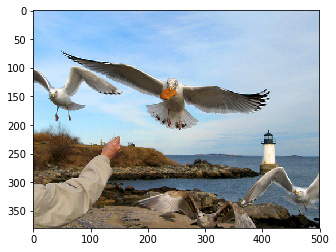

In [10]:
plt.imshow(plt.imread(train_images[1]))
train_captions[1]

### Limit the Size of Dataset

In [11]:
num_images_dataset=512000
train_captions=train_captions[:num_images_dataset]
train_images=train_images[:num_images_dataset] 
len(train_images)

512000

### Encoding of Image using VGG-16

#### Loading the VGG-16 pre-trained weights

In [12]:
model_encoder=keras.applications.VGG16(include_top=False,weights='imagenet')

In [13]:
model_encoder.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [14]:
encoded_image_features=keras.Model(model_encoder.input,model_encoder.layers[-1].output)

#### Pre-Processing the Image

In [15]:
def preprocess_image(image_location):
    image=tf.io.read_file(image_location)
    image=tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image,(224, 224))
    image = keras.applications.vgg16.preprocess_input(image)
    return image,image_location

###  Getting VGG-16 Features corresponding to each image

In [16]:
def encode_images(train_images):
    encode_train=[]
    for image_path in train_images:
        if(os.path.exists(image_path+'.npy')==False):
            encode_train.append(image_path)
    print(len(encode_train))

    
    encode_train = sorted(set(encode_train))
    encoded_image=tf.data.Dataset.from_tensor_slices(encode_train)
    encoded_image=encoded_image.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

    
    for image, path in (encoded_image):
      batch_image_features = encoded_image_features(image)
      batch_image_features = tf.reshape(batch_image_features,(batch_image_features.shape[0], -1, batch_image_features.shape[3]))
      
      for bf, p in zip(batch_image_features, path):
            path_of_feature = p.numpy().decode("utf-8")
            #print(path_of_feature+'.npy')
            if(os.path.exists(path_of_feature+'.npy')==False):
               # print('2'+path_of_feature)
                np.save(path_of_feature, bf.numpy())      

In [17]:
#encode_images(train_images)

### Preprocessing the Captions

In [18]:
max_caption_length=max([len(caption) for caption in train_captions])

In [19]:
vocabulary_size=25000

In [20]:
max_caption_length

264

In [21]:
tokenizer=keras.preprocessing.text.Tokenizer(num_words=vocabulary_size, oov_token='<unk>', filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

In [22]:
tokenizer.fit_on_texts(train_captions)

In [23]:
train_captions=tokenizer.texts_to_sequences(train_captions)

### Pad text sequences to fixed length

In [24]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [25]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
padded_captions=keras.preprocessing.sequence.pad_sequences(train_captions, padding='post')

In [27]:
len(padded_captions[1])

52

In [28]:
train_images, validation_images, train_captions, validation_captions = train_test_split(train_images,
                                                                    padded_captions,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [29]:
BATCH_SIZE=128
BUFFER_SIZE=1000
EMBEDDING_DIM=256
units=512
vocab_size=len(tokenizer.word_index)+1
num_steps=len(train_images)//BATCH_SIZE
attention_dim=49
channel_dim=512

In [30]:
vocab_size

26320

In [50]:
len(tokenizer.word_index) + 1

26320

#### Loading the saved image features

In [31]:
def load_image_features(image_name, caption):
  image_tensor = np.load(image_name.decode('utf-8')+'.npy')
  return image_tensor, caption

In [32]:
dataset = tf.data.Dataset.from_tensor_slices((train_images, train_captions))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          load_image_features, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Deep Learning Architecture

In [33]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [34]:
class Encoder(keras.Model):
    
    def __init__(self,EMBEDDING_DIM):
        super(Encoder,self).__init__()
        self.dense_fc=keras.layers.Dense(EMBEDDING_DIM)  #Shape=(batch_size, 49 , embedding_dim)
    
    def call(self, input_dim):
        return(tf.nn.relu(self.dense_fc(input_dim)))

In [35]:
class Decoder(keras.Model):
    
    def __init__(self, embedding_dim, units, vocab_size):
        super(Decoder,self).__init__()
        self.units=units
        self.attention=BahdanauAttention(self.units)         
        self.embedding =keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru=keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform',recurrent_dropout=0.3)
        self.dropout1=keras.layers.Dropout(rate=0.25)
        self.dropout2=keras.layers.Dropout(rate=0.25)

        self.fc1=keras.layers.Dense(self.units)
        self.fc2=keras.layers.Dense(vocab_size)
    
    def call(self, input_vec ,features, state_hidden):
        context_vector, attention_weights=self.attention(features, state_hidden)
        input_vec=self.embedding(input_vec)
        input_vec= tf.concat([tf.expand_dims(context_vector, 1), input_vec], axis=-1)
        input_vec=self.dropout1(input_vec)
        output,state_hidden=self.gru(input_vec)
        output=self.dropout2(output)
        input_vec= self.fc1(output)
        input_vec = tf.reshape(input_vec, (-1, input_vec.shape[2]))
        input_vec = self.fc2(input_vec)
        return input_vec, state_hidden, attention_weights

    def reset_state(self, batch_size):
         return tf.zeros((batch_size, self.units))

In [36]:
Image_encoder =Encoder(EMBEDDING_DIM)
Text_decoder = Decoder(EMBEDDING_DIM, units, vocab_size)

In [37]:
optimizer = tf.keras.optimizers.Adam()
loss_objective = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_objective(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [38]:
checkpoint_path = ".//512000-GRU//512000-GRU"
ckpt = tf.train.Checkpoint(encoder=Image_encoder,
                           decoder=Text_decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [39]:
ckpt.restore(ckpt_manager.latest_checkpoint)


In [40]:
ckpt_manager.latest_checkpoint

'.//512000-GRU//512000-GRU\\ckpt-25'

In [41]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [42]:
loss_history=[]

In [41]:
@tf.function
def train_step(img_tensor, target):
  loss = 0
  hidden = Text_decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = Image_encoder(img_tensor)

      for i in range(1, target.shape[1]):
          predictions, hidden, _ = Text_decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = Image_encoder.trainable_variables + Text_decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss



In [41]:
EPOCHS = 26

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        #time.sleep(0.2)
        print(img_tensor.shape, target.shape)
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_history.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save(checkpoint_number=epoch)

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))



(128, 49, 512) (128, 52)
Epoch 1 Batch 0 Loss 2.1877
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 52)
(128, 49, 512) (128, 5

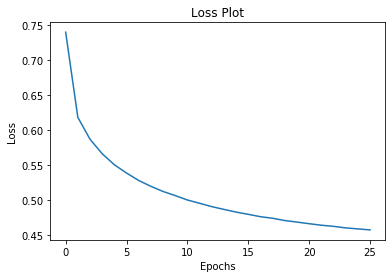

<Figure size 432x288 with 0 Axes>

In [42]:
plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()
plt.savefig('GRU_256-512_512000.png')
with open('GRU_loss1_256-512_512000.txt', 'w') as file:
    for line in loss_history:
        file.write(str(np.asarray(line)))
        file.write('\n')

In [43]:
def evaluate(image):
    attention_plot = np.zeros((max_caption_length, attention_dim))

    hidden = Text_decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0)
    img_tensor_val = encoded_image_features(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = Image_encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_caption_length):
        predictions, hidden, attention_weights = Text_decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


In [44]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

C:\Govind\Course Work\SML\Project\train2017\train2017\\000000070434.jpg
<start> the bathroom has a sink toilet and glass shower <end>
Real Caption: <start> the bathroom has a sink toilet and glass shower <end>
Prediction Caption: a bathroom with a toilet and a toilet <end>


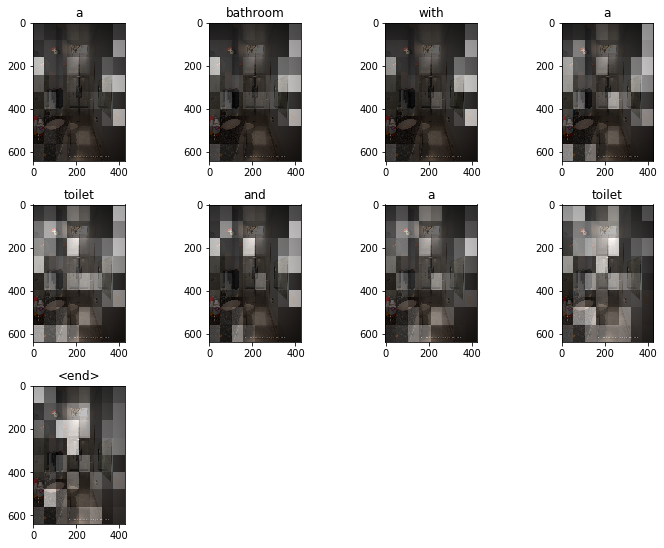

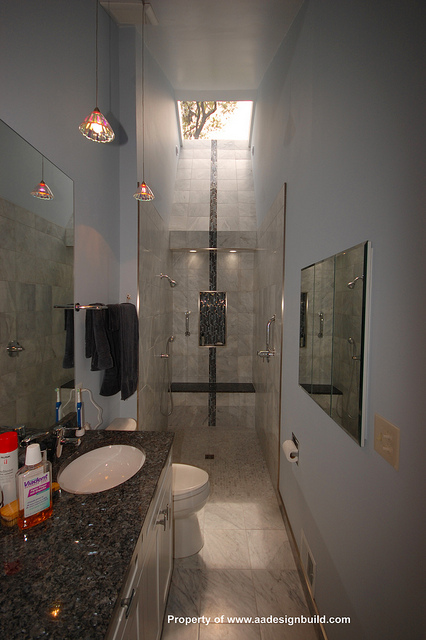

In [45]:
# captions on the validation set
rid = np.random.randint(0, len(validation_images))
image = validation_images[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in validation_captions[rid] if i not in [0]])
print(real_caption)
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(validation_images[rid])